# Problem Statement:
We here have a hierarchical data for products for Walmart store for different categories from three states namely, California, Winscoin and Texas. Looking at this data we need to predict the sales for the products for 28 days. The training data that we have consist of individual sales for each product for 1914 days. Using this train data we need to make prediction on the next days.

We have the following files provided from as the part of the competition:

calendar.csv - Contains information about the dates on which the products are sold.
sales_train_validation.csv - Contains the historical daily unit sales data per product and store [d_1 - d_1913]
sample_submission.csv - The correct format for submissions. Reference the Evaluation tab for more info.
sell_prices.csv - Contains information about the price of the products sold per store and date.
sales_train_evaluation.csv - Includes sales [d_1 - d_1941] (labels used for the Public leaderboard)
Using this dataset we need to make the sales prediction for the next 28 days.

# Doing Necessary Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import random
from sklearn.preprocessing import OrdinalEncoder
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pywt
import math
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from IPython.display import Image
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.tsa.arima_model import ARIMA


from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings("ignore")

# Importing the Data

In [2]:
calendar_pd=pd.read_csv('C:\M5 Forecasting\calendar.csv')
sales_train_eval_pd=pd.read_csv('C:\M5 Forecasting\sales_train_evaluation.csv')
sales_train_valid_pd=pd.read_csv('C:\M5 Forecasting\sales_train_validation.csv')
sell_price_pd=pd.read_csv('C:\M5 Forecasting\sell_prices.csv')
submission=pd.read_csv('C:\M5 Forecasting\sample_submission.csv')

# Basic Statistical Model Building

Now, as we did the EDA, it is time to proceed for the modeling and featurization process. Let us first begin with the basic statistical model commonly used for time series forecasting.

# Train/Test/Val Data Split:
So, let us first split our data in train, validation and test dataset, for the analysis purpose. We have in total 1947 days. So, we will use 1800 days as our train dataset, 100 days following as the validation dataset and remainign 41 days as test dataset.

In [3]:
#splitting the days for train test and evaluation

d_cols=[ele for ele in sales_train_eval_pd if 'd_' in ele]
d_cols_train=d_cols[:1800]
d_cols_valid=d_cols[1800:1900]
d_cols_test=d_cols[1900:]

In [4]:
#creating three separate dataframes for train test and evluation

train_data_sales=sales_train_eval_pd[list(set(sales_train_valid_pd.columns)-set(d_cols))+d_cols_train]
valid_data_sales=sales_train_eval_pd[list(set(sales_train_valid_pd.columns)-set(d_cols))+d_cols_valid]
test_data_sales=sales_train_eval_pd[list(set(sales_train_valid_pd.columns)-set(d_cols))+d_cols_test]

In [5]:
train_sales=train_data_sales[d_cols_train+['id']].set_index('id').T
valid_sales=valid_data_sales[d_cols_valid+['id']].set_index('id').T
test_sales=test_data_sales[d_cols_test+['id']].set_index('id').T


In [6]:
def moving_avg(array,stride,size):
    temp=[]
    for i in range(0,len(array)-size,stride):
        temp.append(np.mean(array[i:size+i]))
    return temp

def pred_sales_avg(array,size):
    temp=[]

    for i in range(len(array)-size):
        if (np.mean(array[i:size+i]))%1 >=0.5:
            temp.append(math.ceil(np.mean(array[i:size+i])))
        else:
            temp.append(math.floor(np.mean(array[i:size+i])))
            
        
    avg=math.ceil(np.mean(array[i:size+i]))
    
    
    for i in range(size):
        temp.append(avg)
    return temp


# Basic Moving Average Approach Approach:

In this method we take an average window and say that the sales for the next day will be the mean of the sales in past k days. Here k is the window size that we choose to calculate moving average. So, let us try out the same with different k values and see how our model performs.

In [7]:
#for window size =20

HOBBIES_1_001_CA_1_evaluation_train_pred=pred_sales_avg(train_sales['HOBBIES_1_001_CA_1_evaluation'],20)
HOBBIES_1_001_CA_1_evaluation_valid_pred=pred_sales_avg(valid_sales['HOBBIES_1_001_CA_1_evaluation'],20)


FOODS_3_090_CA_3_evaluation_train_pred=pred_sales_avg(train_sales['FOODS_3_090_CA_3_evaluation'],20)
FOODS_3_090_CA_3_evaluation_valid_pred=pred_sales_avg(valid_sales['FOODS_3_090_CA_3_evaluation'],20)


HOUSEHOLD_1_118_CA_3_evaluation_train_pred=pred_sales_avg(train_sales['HOUSEHOLD_1_118_CA_3_evaluation'],20)
HOUSEHOLD_1_118_CA_3_evaluation_valid_pred=pred_sales_avg(valid_sales['HOUSEHOLD_1_118_CA_3_evaluation'],20)


# Predicted V/s Actual Values for Train & Valid Dataset

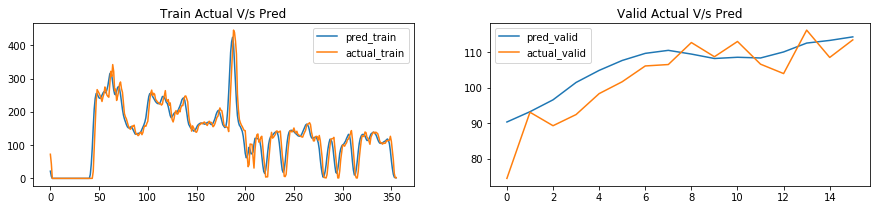

In [8]:
#Train_data plot for FOODS_3_090_CA_3

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))
moving_avg_df_tr=pd.DataFrame({'pred_train':moving_avg(FOODS_3_090_CA_3_evaluation_train_pred,5,20),'actual_train':moving_avg(train_sales['FOODS_3_090_CA_3_evaluation'],5,20)})
moving_avg_df_tr.plot(ax=ax1,title='Train Actual V/s Pred')


moving_avg_df_valid=pd.DataFrame({'pred_valid':moving_avg(FOODS_3_090_CA_3_evaluation_valid_pred,5,20),'actual_valid':moving_avg(valid_sales['FOODS_3_090_CA_3_evaluation'],5,20)})
moving_avg_df_valid.plot(ax=ax2,title='Valid Actual V/s Pred')



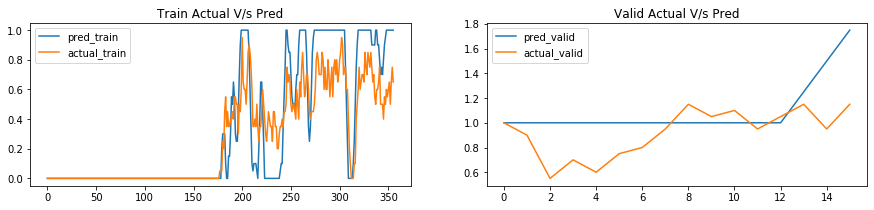

In [9]:
#Train_data plot for FHOBBIES_1_001_CA_1_evaluation

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))
moving_avg_df_tr=pd.DataFrame({'pred_train':moving_avg(HOBBIES_1_001_CA_1_evaluation_train_pred,5,20),'actual_train':moving_avg(train_sales['HOBBIES_1_001_CA_1_evaluation'],5,20)})
moving_avg_df_tr.plot(ax=ax1,title='Train Actual V/s Pred')


moving_avg_df_valid=pd.DataFrame({'pred_valid':moving_avg(HOBBIES_1_001_CA_1_evaluation_valid_pred,5,20),'actual_valid':moving_avg(valid_sales['HOBBIES_1_001_CA_1_evaluation'],5,20)})
moving_avg_df_valid.plot(ax=ax2,title='Valid Actual V/s Pred')

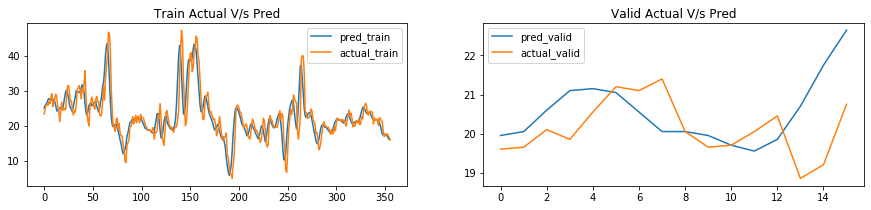

In [10]:
#Train_data plot for HOUSEHOLD_1_118_CA_3_evaluation

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))
moving_avg_df_tr=pd.DataFrame({'pred_train':moving_avg(HOUSEHOLD_1_118_CA_3_evaluation_train_pred,5,20),'actual_train':moving_avg(train_sales['HOUSEHOLD_1_118_CA_3_evaluation'],5,20)})
moving_avg_df_tr.plot(ax=ax1,title='Train Actual V/s Pred')


moving_avg_df_valid=pd.DataFrame({'pred_valid':moving_avg(HOUSEHOLD_1_118_CA_3_evaluation_valid_pred,5,20),'actual_valid':moving_avg(valid_sales['HOUSEHOLD_1_118_CA_3_evaluation'],5,20)})
moving_avg_df_valid.plot(ax=ax2,title='Valid Actual V/s Pred')

# Observations:
For all the three randomy picked items we can see that sales graph for actua validation data and predicted validation data vary quite well. As, this is the naive model. So, let us apply this prediction on the complete dataset and see the error that we get from here.

# Average Window Size 10:

Let us try predicting with the average window size 10.

In [11]:
HOBBIES_1_001_CA_1_evaluation_train_pred=pred_sales_avg(train_sales['HOBBIES_1_001_CA_1_evaluation'],10)
HOBBIES_1_001_CA_1_evaluation_valid_pred=pred_sales_avg(valid_sales['HOBBIES_1_001_CA_1_evaluation'],10)


FOODS_3_090_CA_3_evaluation_train_pred=pred_sales_avg(train_sales['FOODS_3_090_CA_3_evaluation'],10)
FOODS_3_090_CA_3_evaluation_valid_pred=pred_sales_avg(valid_sales['FOODS_3_090_CA_3_evaluation'],10)


HOUSEHOLD_1_118_CA_3_evaluation_train_pred=pred_sales_avg(train_sales['HOUSEHOLD_1_118_CA_3_evaluation'],10)
HOUSEHOLD_1_118_CA_3_evaluation_valid_pred=pred_sales_avg(valid_sales['HOUSEHOLD_1_118_CA_3_evaluation'],10)

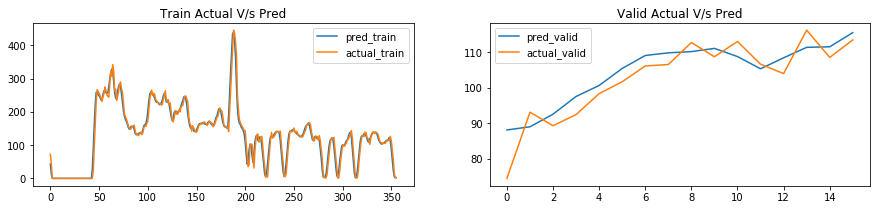

In [12]:
#Train_data plot for FOODS_3_090_CA_3

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))
moving_avg_df_tr=pd.DataFrame({'pred_train':moving_avg(FOODS_3_090_CA_3_evaluation_train_pred,5,20),'actual_train':moving_avg(train_sales['FOODS_3_090_CA_3_evaluation'],5,20)})
moving_avg_df_tr.plot(ax=ax1,title='Train Actual V/s Pred')


moving_avg_df_valid=pd.DataFrame({'pred_valid':moving_avg(FOODS_3_090_CA_3_evaluation_valid_pred,5,20),'actual_valid':moving_avg(valid_sales['FOODS_3_090_CA_3_evaluation'],5,20)})
moving_avg_df_valid.plot(ax=ax2,title='Valid Actual V/s Pred')

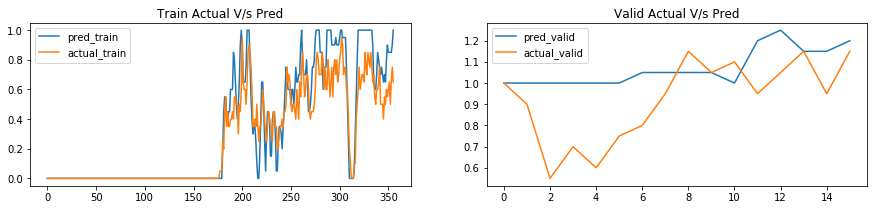

In [13]:
#Train_data plot for FHOBBIES_1_001_CA_1_evaluation

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))
moving_avg_df_tr=pd.DataFrame({'pred_train':moving_avg(HOBBIES_1_001_CA_1_evaluation_train_pred,5,20),'actual_train':moving_avg(train_sales['HOBBIES_1_001_CA_1_evaluation'],5,20)})
moving_avg_df_tr.plot(ax=ax1,title='Train Actual V/s Pred')


moving_avg_df_valid=pd.DataFrame({'pred_valid':moving_avg(HOBBIES_1_001_CA_1_evaluation_valid_pred,5,20),'actual_valid':moving_avg(valid_sales['HOBBIES_1_001_CA_1_evaluation'],5,20)})
moving_avg_df_valid.plot(ax=ax2,title='Valid Actual V/s Pred')

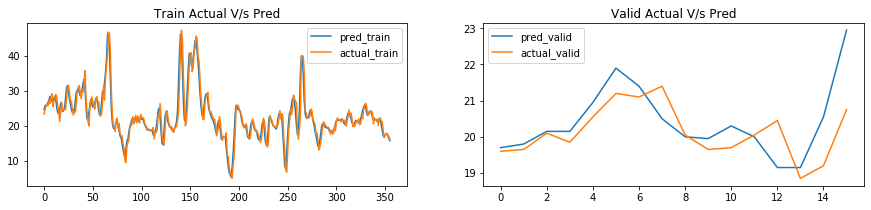

In [14]:
#Train_data plot for HOUSEHOLD_1_118_CA_3_evaluation

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))
moving_avg_df_tr=pd.DataFrame({'pred_train':moving_avg(HOUSEHOLD_1_118_CA_3_evaluation_train_pred,5,20),'actual_train':moving_avg(train_sales['HOUSEHOLD_1_118_CA_3_evaluation'],5,20)})
moving_avg_df_tr.plot(ax=ax1,title='Train Actual V/s Pred')


moving_avg_df_valid=pd.DataFrame({'pred_valid':moving_avg(HOUSEHOLD_1_118_CA_3_evaluation_valid_pred,5,20),'actual_valid':moving_avg(valid_sales['HOUSEHOLD_1_118_CA_3_evaluation'],5,20)})
moving_avg_df_valid.plot(ax=ax2,title='Valid Actual V/s Pred')

# Observations:

We see that for window size 10 our actual and predicted dataset are closer. Hence, we take this window size 10 and predict the values for 28 days for all our products.

In [15]:
def pred_sales(array,size,days):
    temp=[]
    sum1=sum(array)
   
    if (np.mean(array))%1 >=0.5:
        temp.append(math.ceil(np.mean(array)))
    else:
        temp.append(math.floor(np.mean(array)))
        
    for i in range(days):
        if i <len(array):
            new_sum=sum1+temp[i]-array[i]
        else:
            new_sum=sum1+temp[i]-temp[i-size]
            
        
        if ((new_sum)/size)%1 >=0.5:
            temp.append(math.ceil((new_sum)/size))
        else:
            temp.append(math.floor((new_sum)/size))
        
    return temp[:-1]


def error_eval(actual_df,pred_df):
    temp=[]
    for ele in actual_df.columns:
        temp.append(mean_squared_error(actual_df[ele],pred_df[ele]))
    return np.mean(temp)


In [16]:
temp1=pred_sales(train_sales['HOBBIES_1_001_CA_1_evaluation'][-20:],20,100)
temp2=pred_sales_avg(train_sales['HOBBIES_1_001_CA_1_evaluation'][-28:],10)

In [17]:
pred_avg_dict={}

for ele in tqdm(train_sales.columns):
    pred_avg_dict[ele]=pred_sales(train_sales[ele][-20:],20,len(d_cols_valid))
    
pred_avg_df=pd.DataFrame(pred_avg_dict,index=d_cols_valid)
pred_avg_df.tail()
    

100%|██████████| 30490/30490 [00:24<00:00, 1245.92it/s]


,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_010_CA_1_evaluation,...,FOODS_3_818_WI_3_evaluation,FOODS_3_819_WI_3_evaluation,FOODS_3_820_WI_3_evaluation,FOODS_3_821_WI_3_evaluation,FOODS_3_822_WI_3_evaluation,FOODS_3_823_WI_3_evaluation,FOODS_3_824_WI_3_evaluation,FOODS_3_825_WI_3_evaluation,FOODS_3_826_WI_3_evaluation,FOODS_3_827_WI_3_evaluation
d_1896,1,1,1,2,2,0,0,9,0,1,...,3,2,2,2,2,1,0,1,1,1
d_1897,1,1,1,2,2,0,0,9,0,1,...,3,2,2,2,2,1,0,1,1,1
d_1898,1,1,1,2,2,0,0,9,0,1,...,3,2,2,2,2,1,0,1,1,1
d_1899,1,1,1,2,2,0,0,9,0,1,...,3,2,2,2,2,1,0,1,1,1
d_1900,1,1,1,2,2,0,0,9,0,1,...,3,2,2,2,2,1,0,1,1,1


In [18]:
rmse_valid_mov_avg=error_eval(valid_sales,pred_avg_df)

In [19]:
print('With Moving Average we get Mean Squared Error on our Validation dataset as: ',rmse_valid_mov_avg)

With Moving Average we get Mean Squared Error on our Validation dataset as:  7.65169104624467


# Holt Linear Method

Holt linear attempts to capture the high-level trends in time series data using a linear function. The method can be summarized as follows:

Forecast, level, and trend equations respectively:
    




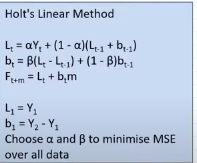

In [20]:
Image('holt_img.png')
#reference:https://www.youtube.com/watch?v=zBD9AlD4AbY&t=274s


In the above equations,  α  and  β  are constants which can be configured. The values lt and bt represent the level and trend values repsectively. The trend value is the slope of the linear forecast function and the level value is the y-intercept of the linear forecast function. The slope and y-intercept values are continuously updated using the second and third update equations. Finally, the slope and y-intercept values are used to calculate the foreca

In [21]:
def holt_linear(array):
    alpha=0.4
    beta=0.3
    
    #initial values of l1 and b1
    l1=array[0]
    b1=array[1]-array[0]
    
    #forecast value for each day
    forecast_values=[l1+b1]
    
   
    
    for i in range(1,len(array)):
        lt=alpha*array[i]+(1-alpha)*(l1+b1)
        bt=beta*(lt-l1)+(1-beta)*b1
        forecast_values.append(l1+bt)
        l1=lt
        b1=bt
    return forecast_values

In [22]:
#holt linear method prediction

HOBBIES_1_001_CA_1_evaluation_train_pred=holt_linear(train_sales['HOBBIES_1_001_CA_1_evaluation'])
HOBBIES_1_001_CA_1_evaluation_valid_pred=holt_linear(valid_sales['HOBBIES_1_001_CA_1_evaluation'])


FOODS_3_090_CA_3_evaluation_train_pred=holt_linear(train_sales['FOODS_3_090_CA_3_evaluation'])
FOODS_3_090_CA_3_evaluation_valid_pred=holt_linear(valid_sales['FOODS_3_090_CA_3_evaluation'])


HOUSEHOLD_1_118_CA_3_evaluation_train_pred=holt_linear(train_sales['HOUSEHOLD_1_118_CA_3_evaluation'])
HOUSEHOLD_1_118_CA_3_evaluation_valid_pred=holt_linear(valid_sales['HOUSEHOLD_1_118_CA_3_evaluation'])

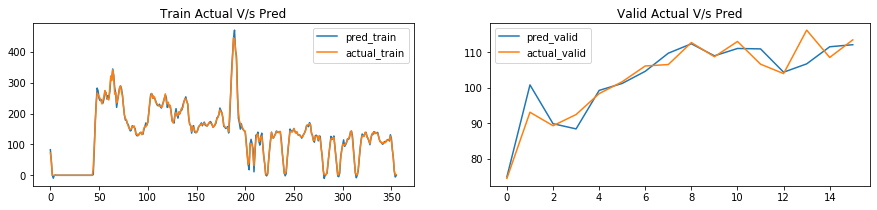

In [23]:
#Train_data plot for FOODS_3_090_CA_3

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))
moving_avg_df_tr=pd.DataFrame({'pred_train':moving_avg(FOODS_3_090_CA_3_evaluation_train_pred,5,20),'actual_train':moving_avg(train_sales['FOODS_3_090_CA_3_evaluation'],5,20)})
moving_avg_df_tr.plot(ax=ax1,title='Train Actual V/s Pred')


moving_avg_df_valid=pd.DataFrame({'pred_valid':moving_avg(FOODS_3_090_CA_3_evaluation_valid_pred,5,20),'actual_valid':moving_avg(valid_sales['FOODS_3_090_CA_3_evaluation'],5,20)})
moving_avg_df_valid.plot(ax=ax2,title='Valid Actual V/s Pred')

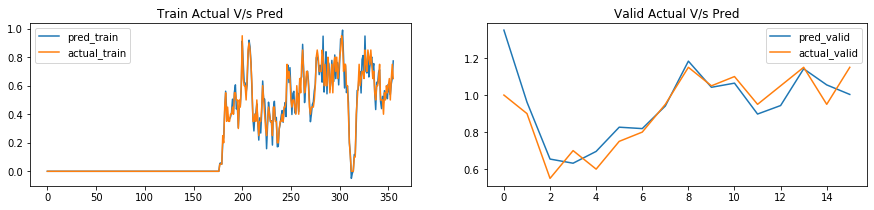

In [24]:
#Train_data plot for FHOBBIES_1_001_CA_1_evaluation

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))
moving_avg_df_tr=pd.DataFrame({'pred_train':moving_avg(HOBBIES_1_001_CA_1_evaluation_train_pred,5,20),'actual_train':moving_avg(train_sales['HOBBIES_1_001_CA_1_evaluation'],5,20)})
moving_avg_df_tr.plot(ax=ax1,title='Train Actual V/s Pred')


moving_avg_df_valid=pd.DataFrame({'pred_valid':moving_avg(HOBBIES_1_001_CA_1_evaluation_valid_pred,5,20),'actual_valid':moving_avg(valid_sales['HOBBIES_1_001_CA_1_evaluation'],5,20)})
moving_avg_df_valid.plot(ax=ax2,title='Valid Actual V/s Pred')

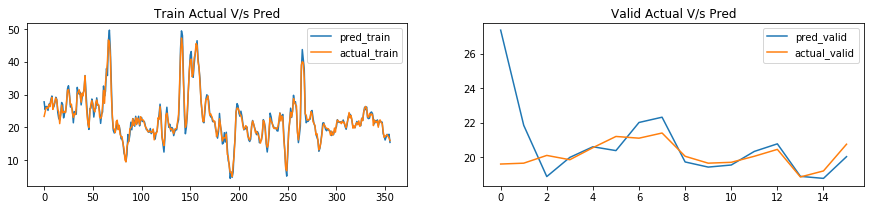

In [25]:
#Train_data plot for HOUSEHOLD_1_118_CA_3_evaluation

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))
moving_avg_df_tr=pd.DataFrame({'pred_train':moving_avg(HOUSEHOLD_1_118_CA_3_evaluation_train_pred,5,20),'actual_train':moving_avg(train_sales['HOUSEHOLD_1_118_CA_3_evaluation'],5,20)})
moving_avg_df_tr.plot(ax=ax1,title='Train Actual V/s Pred')


moving_avg_df_valid=pd.DataFrame({'pred_valid':moving_avg(HOUSEHOLD_1_118_CA_3_evaluation_valid_pred,5,20),'actual_valid':moving_avg(valid_sales['HOUSEHOLD_1_118_CA_3_evaluation'],5,20)})
moving_avg_df_valid.plot(ax=ax2,title='Valid Actual V/s Pred')

# Observation:
From the above plots we can see that in case of Holt Linear method our curves overlap more. Hence, we get better plots. This method thus is better than the moving average process.

In [26]:
def holt_linear_pred(array,days):
    alpha=0.25
    beta=0.01
    
    #initial values of l1 and b1
    l1=array[0]
    b1=array[1]-array[0]
    
    #forecast value for each day
    forecast_values=[]
    
   
    
    for i in range(1,len(array)):
        lt=alpha*array[i]+(1-alpha)*(l1+b1)
        bt=beta*(lt-l1)+(1-beta)*b1
        ft=l1+bt
        l1=lt
        b1=bt
    
        
    for i in range(days):
        
        lt=alpha*ft+(1-alpha)*(l1+b1)
        bt=beta*(lt-l1)+(1-beta)*b1
        
        ft=lt+bt
        forecast_values.append(math.ceil(ft))
        l1=lt
        b1=bt
        
        
    return forecast_values

In [27]:
pred_hotlinear_dict={}

for ele in tqdm(train_sales.columns):
    pred_hotlinear_dict[ele]=holt_linear_pred(train_sales[ele],len(d_cols_valid))
    
pred_holtlinear_df=pd.DataFrame(pred_hotlinear_dict,index=d_cols_valid)
pred_holtlinear_df.tail()
    

100%|██████████| 30490/30490 [23:04<00:00, 22.02it/s] 


,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_010_CA_1_evaluation,...,FOODS_3_818_WI_3_evaluation,FOODS_3_819_WI_3_evaluation,FOODS_3_820_WI_3_evaluation,FOODS_3_821_WI_3_evaluation,FOODS_3_822_WI_3_evaluation,FOODS_3_823_WI_3_evaluation,FOODS_3_824_WI_3_evaluation,FOODS_3_825_WI_3_evaluation,FOODS_3_826_WI_3_evaluation,FOODS_3_827_WI_3_evaluation
d_1896,1,0,2,3,0,0,1,12,1,1,...,3,4,1,2,3,1,0,2,0,-1
d_1897,1,0,2,3,0,0,1,12,1,1,...,3,4,1,2,3,1,0,2,0,-1
d_1898,1,0,2,3,0,0,1,12,1,1,...,3,4,1,2,3,1,0,2,0,-1
d_1899,1,0,2,3,0,0,1,12,1,1,...,3,4,1,2,3,1,0,2,0,-1
d_1900,1,0,2,3,0,0,1,12,1,1,...,3,4,1,2,3,1,0,2,0,-1


In [28]:
rmse_valid_holt=error_eval(valid_sales,pred_holtlinear_df)

In [29]:
rmse_valid_holt

11.755923909478517

# Exponential Smoothing

This works on the assumption that as we proceed on in a time series the values get more and more dependent on the recently viewd data and less dependent on the data values seen before. Hence, as we proceed we give less weightage to the values viewed before.

This method gives different weightage to different time steps, instead of giving the same weightage to all time steps (like the moving average method). This ensures that recent sales data is given more importance than old sales data while making the forecast

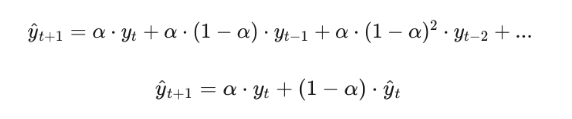

In [30]:
Image('exponen_smooth.png')

In [31]:
def exponential_smoothing(array):
    f0=array[0]
    alpha=0.2
    forecast_values=[f0]
    
    for i in range(1,len(array)):
        ft=alpha*array[i]+(1-alpha)*f0
        forecast_values.append(ft)
        f0=ft
    return forecast_values
        
        

In [32]:
#exponential decaying method prediction

HOBBIES_1_001_CA_1_evaluation_train_pred=exponential_smoothing(train_sales['HOBBIES_1_001_CA_1_evaluation'])
HOBBIES_1_001_CA_1_evaluation_valid_pred=exponential_smoothing(valid_sales['HOBBIES_1_001_CA_1_evaluation'])


FOODS_3_090_CA_3_evaluation_train_pred=exponential_smoothing(train_sales['FOODS_3_090_CA_3_evaluation'])
FOODS_3_090_CA_3_evaluation_valid_pred=exponential_smoothing(valid_sales['FOODS_3_090_CA_3_evaluation'])


HOUSEHOLD_1_118_CA_3_evaluation_train_pred=exponential_smoothing(train_sales['HOUSEHOLD_1_118_CA_3_evaluation'])
HOUSEHOLD_1_118_CA_3_evaluation_valid_pred=exponential_smoothing(valid_sales['HOUSEHOLD_1_118_CA_3_evaluation'])

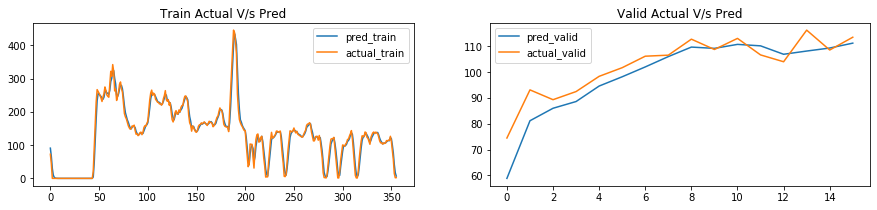

In [33]:
#Train_data plot for FOODS_3_090_CA_3

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))
moving_avg_df_tr=pd.DataFrame({'pred_train':moving_avg(FOODS_3_090_CA_3_evaluation_train_pred,5,20),'actual_train':moving_avg(train_sales['FOODS_3_090_CA_3_evaluation'],5,20)})
moving_avg_df_tr.plot(ax=ax1,title='Train Actual V/s Pred')


moving_avg_df_valid=pd.DataFrame({'pred_valid':moving_avg(FOODS_3_090_CA_3_evaluation_valid_pred,5,20),'actual_valid':moving_avg(valid_sales['FOODS_3_090_CA_3_evaluation'],5,20)})
moving_avg_df_valid.plot(ax=ax2,title='Valid Actual V/s Pred')

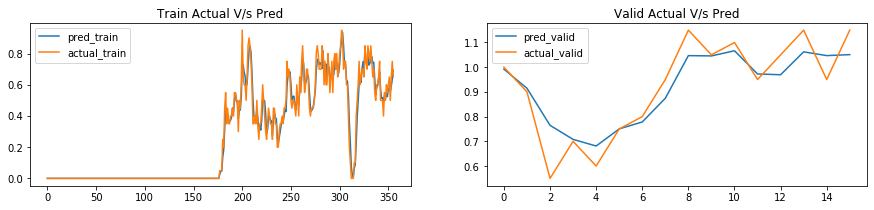

In [34]:
#Train_data plot for FHOBBIES_1_001_CA_1_evaluation

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))
moving_avg_df_tr=pd.DataFrame({'pred_train':moving_avg(HOBBIES_1_001_CA_1_evaluation_train_pred,5,20),'actual_train':moving_avg(train_sales['HOBBIES_1_001_CA_1_evaluation'],5,20)})
moving_avg_df_tr.plot(ax=ax1,title='Train Actual V/s Pred')


moving_avg_df_valid=pd.DataFrame({'pred_valid':moving_avg(HOBBIES_1_001_CA_1_evaluation_valid_pred,5,20),'actual_valid':moving_avg(valid_sales['HOBBIES_1_001_CA_1_evaluation'],5,20)})
moving_avg_df_valid.plot(ax=ax2,title='Valid Actual V/s Pred')

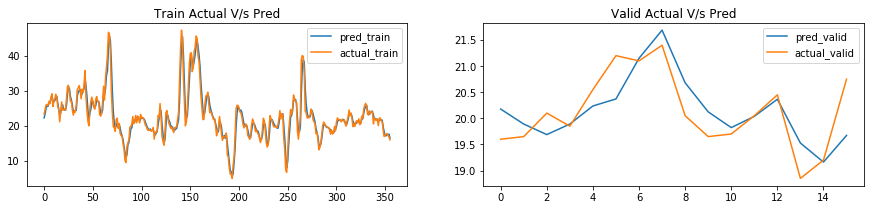

In [35]:
#Train_data plot for HOUSEHOLD_1_118_CA_3_evaluation

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))
moving_avg_df_tr=pd.DataFrame({'pred_train':moving_avg(HOUSEHOLD_1_118_CA_3_evaluation_train_pred,5,20),'actual_train':moving_avg(train_sales['HOUSEHOLD_1_118_CA_3_evaluation'],5,20)})
moving_avg_df_tr.plot(ax=ax1,title='Train Actual V/s Pred')


moving_avg_df_valid=pd.DataFrame({'pred_valid':moving_avg(HOUSEHOLD_1_118_CA_3_evaluation_valid_pred,5,20),'actual_valid':moving_avg(valid_sales['HOUSEHOLD_1_118_CA_3_evaluation'],5,20)})
moving_avg_df_valid.plot(ax=ax2,title='Valid Actual V/s Pred')

# Observation:

When there was a sudden increase or drop in sales then holt linear method was not captured properly. But we are able to capture these details with the help of exponential decaying method

In [36]:
def exponential_smoothing_pred(array,days):
    f0=array[0]
    alpha=0.2
    forecast_values=[]
    
    for i in range(1,len(array)):
        ft=alpha*array[i]+(1-alpha)*f0
        f0=ft
    
    f0=array[-1]
    for i in range(days):
        ft=alpha*f0+(1-alpha)*ft
        #print(ft)
        forecast_values.append(math.ceil(ft))
        f0=ft
        
    return forecast_values

In [37]:
pred_exponential_smoothing_dict={}

for ele in tqdm(train_sales.columns):
    pred_exponential_smoothing_dict[ele]=exponential_smoothing_pred(train_sales[ele],len(d_cols_valid))
    
pred_exponential_smoothing_df=pd.DataFrame(pred_exponential_smoothing_dict,index=d_cols_valid)
pred_exponential_smoothing_df.tail()
    

100%|██████████| 30490/30490 [20:48<00:00, 24.42it/s]


,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_010_CA_1_evaluation,...,FOODS_3_818_WI_3_evaluation,FOODS_3_819_WI_3_evaluation,FOODS_3_820_WI_3_evaluation,FOODS_3_821_WI_3_evaluation,FOODS_3_822_WI_3_evaluation,FOODS_3_823_WI_3_evaluation,FOODS_3_824_WI_3_evaluation,FOODS_3_825_WI_3_evaluation,FOODS_3_826_WI_3_evaluation,FOODS_3_827_WI_3_evaluation
d_1896,1,1,2,3,1,1,1,16,1,1,...,3,4,2,2,3,1,1,2,2,1
d_1897,1,1,2,3,1,1,1,16,1,1,...,3,4,2,2,3,1,1,2,2,1
d_1898,1,1,2,3,1,1,1,16,1,1,...,3,4,2,2,3,1,1,2,2,1
d_1899,1,1,2,3,1,1,1,16,1,1,...,3,4,2,2,3,1,1,2,2,1
d_1900,1,1,2,3,1,1,1,16,1,1,...,3,4,2,2,3,1,1,2,2,1


In [38]:
rmse_valid_exp_smooth=error_eval(valid_sales,pred_exponential_smoothing_df)

In [39]:
rmse_valid_exp_smooth

8.4723325680551

# ARIMA

For using ARIMA we first need to check if the series is stataionary. From our EDA plots we have seen that here are seasonal patterns and different patterns in series on weekly basis. Hence, our series is not stationary. For this we need to do differencing to make the series stationary.

adfuller is a method that helps us check if the series is stationary. If we get a p-value greater than 0.05 it shows that the series is not stationary and we need to do further hypothesis testing.

In [8]:
stationary_vars=[]
for col in train_sales.columns:
    result = adfuller(train_sales[col].dropna())
    if result[1]<=0.05:
        stationary_vars.append(col)


C:\Users\mansi.choudhary\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:889: RuntimeWarning:

divide by zero encountered in log

C:\Users\mansi.choudhary\Anaconda3\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\mansi.choudhary\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

C:\Users\mansi.choudhary\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

C:\Users\mansi.choudhary\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1827: RuntimeWarning:

invalid value encountered in greater_equal



In [10]:
len(train_sales.columns)

30490

In [9]:
len(stationary_vars)

26478

In [11]:
non_stationary_vars=list(set(train_sales.columns)-set(stationary_vars))

Out of 30490 columns we see that 26478 are stationary. Hence, we will perform differencing only on the remaining non-stationary variables.

# Choosing the Differencing Parameter (D)

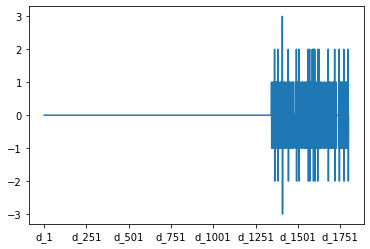

In [12]:
temp=train_sales[non_stationary_vars[0]].diff()
temp.plot()

We see that by 1-ord differencing we are getting good results. Let us apply the same on complete non-stationary variables and check if the variables have now become stationary

In [13]:
stationary_vars_after_diff=[]
for col in non_stationary_vars:
    result = adfuller(train_sales[col].diff().dropna())
    if result[1]<=0.05:
        stationary_vars_after_diff.append(col)

C:\Users\mansi.choudhary\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:889: RuntimeWarning:

divide by zero encountered in log

C:\Users\mansi.choudhary\Anaconda3\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\mansi.choudhary\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

C:\Users\mansi.choudhary\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

C:\Users\mansi.choudhary\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1827: RuntimeWarning:

invalid value encountered in greater_equal



In [14]:
len(stationary_vars_after_diff)

3994

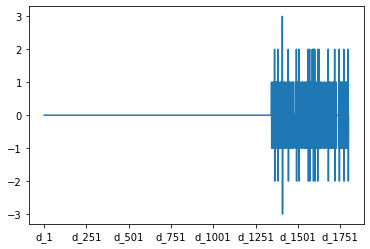

In [15]:
temp=train_sales[stationary_vars_after_diff[0]].diff()
temp.plot()

In [66]:
# 1,1,2 ARIMA Model
import statsmodels.api as sm

print('ARIMA model prediction for FOODS_3_296_CA_1_evaluation')
t1=[0.00001+ele for ele in train_sales['FOODS_3_296_CA_1_evaluation']]
model = sm.tsa.SARIMAX(train_sales['FOODS_3_296_CA_1_evaluation'],order=(0, 1, 1), enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit()
print(model_fit.summary())

ARIMA model prediction for FOODS_3_296_CA_1_evaluation
                                    SARIMAX Results                                    
Dep. Variable:     FOODS_3_296_CA_1_evaluation   No. Observations:                 1800
Model:                        SARIMAX(0, 1, 1)   Log Likelihood               23342.852
Date:                         Fri, 28 Aug 2020   AIC                         -46681.704
Time:                                 12:55:47   BIC                         -46670.717
Sample:                                      0   HQIC                        -46677.648
                                        - 1800                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1       -7.87e-16         -0        inf      0.000   -7.87e-16   -7.87e-16
sigm

In [ ]:
n = 1000
ls = np.linspace(0, 2*np.pi, n)
df1Clean = pd.DataFrame(np.sin(ls))
df2Clean = pd.DataFrame(2*np.sin(ls+1))
dfClean = pd.concat([df1Clean, df2Clean], axis=1)
dfDirty = dfClean+0.00001*np.random.rand(n, 2)

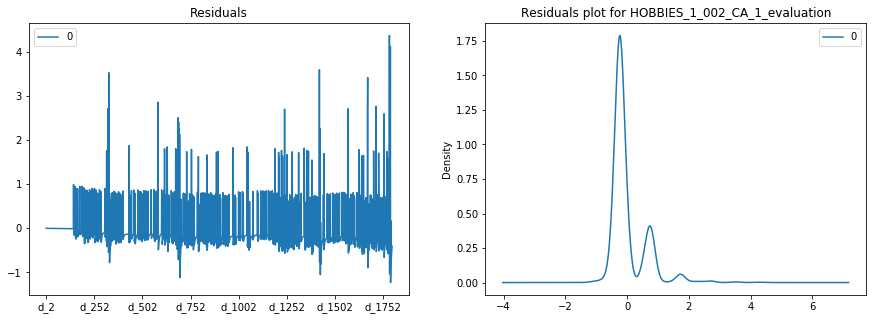

In [22]:
# Plot residual errors

residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0],figsize=(15,5))
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.title('Residuals plot for '+str(stationary_vars[0]))
plt.show()

Our residuals plot show erros for most of the values near zero but in some cases it is diverting from it. Hence, we might need to look out on that front. This might be because we are gettig decimal predictions which might not be getting rounded.

# Actual V/s Predicted

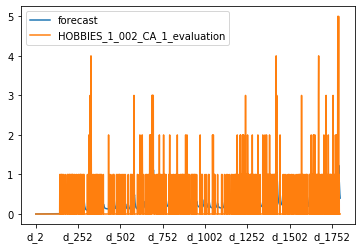

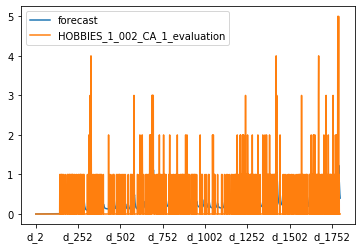

In [27]:
model_fit.plot_predict(dynamic=False)

# Making Predictions with ARIMA

In [40]:
#seperating stationary and non-stationary variables for using different values of difference degree
col_dict={}
for ele in stationary_vars:
    col_dict[ele]=0
for ele in non_stationary_vars:
    col_dict[ele]=1

In [73]:
pred_arima_dict={}

k=0
for ele in train_sales.columns:
    model=sm.tsa.SARIMAX(train_sales[ele],order=(col_dict[ele], 1, 2), enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit()
    temp=model_fit.forecast(len(d_cols_valid))
    fc=list(map(math.ceil,temp))
    pred_arima_dict[ele]=fc
    k=k+1
    if k%100==0:
        print('*',end='')

pred_arima_df=pd.DataFrame(pred_arima_dict,index=d_cols_valid)
pred_arima_df.tail()
    

****************************************************************************************************************************************************************************************************************************************************************************************************************

,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_010_CA_1_evaluation,...,FOODS_3_818_WI_3_evaluation,FOODS_3_819_WI_3_evaluation,FOODS_3_820_WI_3_evaluation,FOODS_3_821_WI_3_evaluation,FOODS_3_822_WI_3_evaluation,FOODS_3_823_WI_3_evaluation,FOODS_3_824_WI_3_evaluation,FOODS_3_825_WI_3_evaluation,FOODS_3_826_WI_3_evaluation,FOODS_3_827_WI_3_evaluation
d_1896,1,1,2,2,2,1,1,11,1,1,...,3,3,2,2,3,1,1,1,2,2
d_1897,1,1,2,2,2,1,1,11,1,1,...,3,3,2,2,3,1,1,1,2,2
d_1898,1,1,2,2,2,1,1,11,1,1,...,3,3,2,2,3,1,1,1,2,2
d_1899,1,1,2,2,2,1,1,11,1,1,...,3,3,2,2,3,1,1,1,2,2
d_1900,1,1,2,2,2,1,1,11,1,1,...,3,3,2,2,3,1,1,1,2,2


In [75]:
arima_error=error_eval(valid_sales,pred_arima_df)

In [76]:
print('Error from ARIMA without an seasonality: ',arima_error)

Error from ARIMA without an seasonality:  7.7268553624139065


# ARIMA with Weekle Seasonality

In [77]:
pred_arima_week_dict={}

k=0
for ele in train_sales.columns:
    model=sm.tsa.SARIMAX(train_sales[ele],order=(col_dict[ele], 1, 7), enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit()
    temp=model_fit.forecast(len(d_cols_valid))
    fc=list(map(math.ceil,temp))
    pred_arima_dict[ele]=fc
    k=k+1
    if k%100==0:
        print('*',end='')

pred_arima_week_df=pd.DataFrame(pred_arima_week_dict,index=d_cols_valid)
pred_arima_week_df.tail()
    

****************************************************************************************************************************************************************************************************************************************************************************************************************

""
d_1896
d_1897
d_1898
d_1899
d_1900


In [80]:
pred_arima_week_df=pd.DataFrame(pred_arima_dict,index=d_cols_valid)
pred_arima_week_df.tail()

,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_010_CA_1_evaluation,...,FOODS_3_818_WI_3_evaluation,FOODS_3_819_WI_3_evaluation,FOODS_3_820_WI_3_evaluation,FOODS_3_821_WI_3_evaluation,FOODS_3_822_WI_3_evaluation,FOODS_3_823_WI_3_evaluation,FOODS_3_824_WI_3_evaluation,FOODS_3_825_WI_3_evaluation,FOODS_3_826_WI_3_evaluation,FOODS_3_827_WI_3_evaluation
d_1896,1,1,2,2,2,1,1,11,1,1,...,3,3,2,2,3,1,1,1,2,2
d_1897,1,1,2,2,2,1,1,11,1,1,...,3,3,2,2,3,1,1,1,2,2
d_1898,1,1,2,2,2,1,1,11,1,1,...,3,3,2,2,3,1,1,1,2,2
d_1899,1,1,2,2,2,1,1,11,1,1,...,3,3,2,2,3,1,1,1,2,2
d_1900,1,1,2,2,2,1,1,11,1,1,...,3,3,2,2,3,1,1,1,2,2


In [81]:
arima_season_error=error_eval(valid_sales,pred_arima_week_df)
print('Error from ARIMA with seasonality: ',arima_season_error)

Error from ARIMA with seasonality:  7.742592981305347


In [40]:
#https://towardsdatascience.com/forecasting-exchange-rates-using-arima-in-python-f032f313fc56
#https://medium.com/fintechexplained/understanding-auto-regressive-model-arima-4bd463b7a1bb
#https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/